In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import pandas_datareader.naver as web_naver

sns.set(style='darkgrid')
sns.set(rc={'figure.figsize':(20,10)})

# pypfopt 모듈을 이용한 포프폴리오 최적화 백테스팅

1. 샤프비율 최대화 포트폴리오, 변동성 최소화 포트폴리오를 구축
2. 첫 12달 데이터를 이용하여 바로 다음 달에 최적화할 mean, variance를 예측 그 후로 달이 지날 수록 데이터를 누적하여 추정
3. 데이터는 KOSPI 자료 

In [2]:
start = '2008-12-01'
end = '2021-11-30'

In [3]:
price_panel=pd.read_csv('price_panel_monthend.csv',index_col=0,parse_dates=True)

In [4]:
print(len(price_panel.columns))

1205


In [5]:
price_panel.dropna(inplace=True,axis=1)

In [6]:
def optimize_weights(prices):
    returns=expected_returns.mean_historical_return(prices=prices)
    cov=risk_models.CovarianceShrinkage(prices).ledoit_wolf()
    ef=EfficientFrontier(expected_returns=returns,
                        cov_matrix=cov,
                        weight_bounds=(0,1))
    ef.add_constraint(lambda x: x>=0)
    ef.max_sharpe()
    return ef.clean_weights()


In [7]:
def optimize_weights2(prices):
    returns=expected_returns.mean_historical_return(prices=prices,frequency=252)
    cov=risk_models.sample_cov(prices=prices,frequency=252)
    ef=EfficientFrontier(expected_returns=returns,
                        cov_matrix=cov,
                        weight_bounds=(0,1))
    ef.add_constraint(lambda x: x>=0)
    ef.max_sharpe()
    return ef.clean_weights()


In [8]:
def optimize_weights3(prices):
    returns=expected_returns.mean_historical_return(prices=prices,frequency=252)
    cov=risk_models.exp_cov(prices=prices,frequency=252)
    ef=EfficientFrontier(expected_returns=returns,
                        cov_matrix=cov,
                        weight_bounds=(0,1))
    ef.add_constraint(lambda x: x>=0)
    ef.max_sharpe()
    return ef.clean_weights()


## 포트폴리오 구축
함수에서 sampe_cov나 exp_cov를 사용하면 오류가 발생함. 따라서 covariance shrinkage를 이용

In [9]:
def max_sharpe(prices,p):
    rtn=np.log(prices/prices.shift(1))*100
    rtn=rtn.iloc[1:]
    rtn=rtn.iloc[p:]
    date_return_tickers=dict()
    for i in range(p,len(rtn)):
        returns=expected_returns.mean_historical_return(prices=prices.iloc[:i])
        cov=risk_models.CovarianceShrinkage(prices.iloc[:i]).ledoit_wolf()
        ef=EfficientFrontier(expected_returns=returns,
                             cov_matrix=cov,
                             weight_bounds=(0,1))
        ef.add_constraint(lambda x:x>=0)
        ef.max_sharpe()
        weights=ef.clean_weights()
        date_return_tickers[rtn.index[i]]=\
        [[np.dot(rtn.iloc[i].fillna(-99).values,np.array(list(weights.values())))],list(weights.keys())]
    return date_return_tickers


In [10]:
def min_volatility(prices,p):
    rtn=np.log(prices/prices.shift(1))*100
    rtn=rtn.iloc[1:]
    rtn.iloc[p:]
    date_return_tickers=dict()
    for i in range(p,len(rtn)):
        returns=expected_returns.mean_historical_return(prices=prices.iloc[:i])
        cov=risk_models.CovarianceShrinkage(prices.iloc[:i]).ledoit_wolf()
        ef=EfficientFrontier(expected_returns=returns,
                             cov_matrix=cov,
                             weight_bounds=(0,1))
        ef.add_constraint(lambda x:x>=0)
        ef.min_volatility()
        weights=ef.clean_weights()
        date_return_tickers[rtn.index[i]]=\
        [[np.dot(rtn.iloc[i].fillna(-99).values,np.array(list(weights.values())))],list(weights.keys())]
    return date_return_tickers


In [11]:
max_sharpe=max_sharpe(price_panel,p=12)
min_volatility=min_volatility(price_panel,p=12)


In [12]:
kospi=web_naver.NaverDailyReader(symbols='KOSPI', start=start,end=end,adjust_price=True)
kospi=kospi.read()
kospi=kospi.astype(float)

In [13]:
kospi=kospi.loc[price_panel.index,:]['Close']
kospi=kospi.iloc[12:]
kospi.head()

Date
2009-12-30    1682.77
2010-01-29    1602.43
2010-02-26    1594.58
2010-03-31    1692.85
2010-04-30    1741.56
Name: Close, dtype: float64

## KOSPI, max_sharpe,min_volatility 비교

In [14]:
portfolio=pd.DataFrame(index=price_panel.index)
portfolio['max_sharpe']=pd.Series(np.array([rtn[0] for rtn in list(max_sharpe.values())]).flatten(),max_sharpe.keys())
portfolio['min_volatility']=pd.Series(np.array([rtn[0] for rtn in list(min_volatility.values())]).flatten(),min_volatility.keys())
portfolio['KOSPI']=np.log(kospi/kospi.shift(1))*100

In [15]:
print("mean","\n",portfolio.mean())
print("")
print("std","\n",portfolio.std())
print("")
print("skewness","\n",portfolio.skew())
print("")
print("kurtosis","\n",portfolio.kurtosis())
print("")
print("sharpe ratio","\n", portfolio.mean() / portfolio.std())

mean 
 max_sharpe       -1.232707
min_volatility    0.335367
KOSPI             0.365744
dtype: float64

std 
 max_sharpe        8.060416
min_volatility    3.758024
KOSPI             4.201275
dtype: float64

skewness 
 max_sharpe       -0.783921
min_volatility   -0.660055
KOSPI            -0.338658
dtype: float64

kurtosis 
 max_sharpe        2.325001
min_volatility    2.413765
KOSPI             1.676392
dtype: float64

sharpe ratio 
 max_sharpe       -0.152933
min_volatility    0.089240
KOSPI             0.087056
dtype: float64


min_volatility 포트폴리오는 준수한 성능을 보이지만 max_sharpe포트폴리오는 그렇지 못함.
변동성을 추정하는 것이 평균을 추정하는 것보다 상대적으로 오류가 적기 때문

<AxesSubplot:xlabel='Date'>

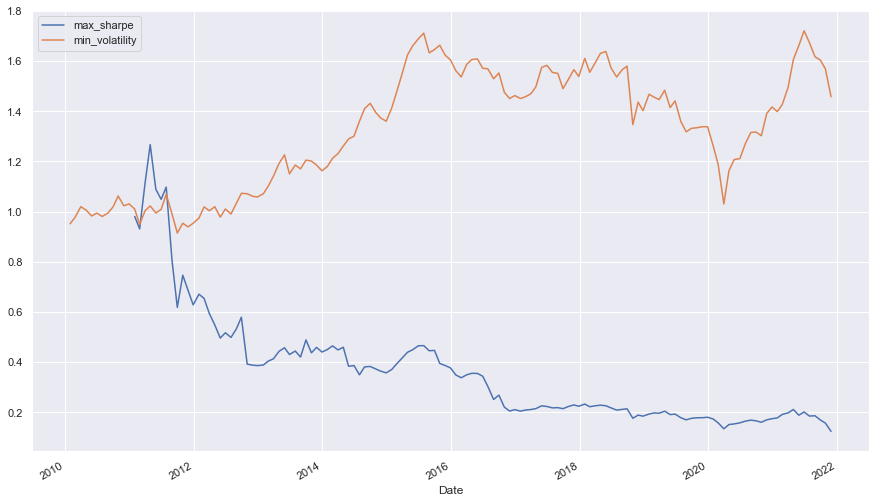

In [16]:
cum_rtn=portfolio[['max_sharpe','min_volatility']]/100
(1+cum_rtn).cumprod().plot(figsize=(15,9))

<AxesSubplot:xlabel='Date'>

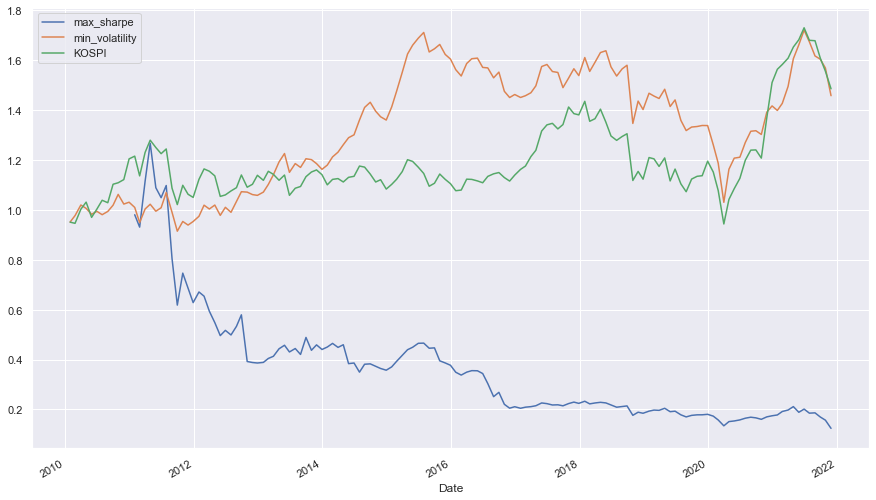

In [17]:
cum_rtn=portfolio[['max_sharpe','min_volatility','KOSPI']]/100
(1+cum_rtn).cumprod().plot(figsize=(15,9))